In [2]:
import numpy as np
import GPy

import matplotlib.pyplot as plt
%matplotlib inline

warning in stationary: failed to import cython module: falling back to numpy


In [224]:
# Methods for combining differential privacy with Gaussian Processes

import GPy
from sklearn.metrics import mean_squared_error
import numpy as np
import sys
import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

class DPGP(object):
    """(epsilon,delta)-Differentially Private Gaussian Process predictions"""
    
    def __init__(self,model,sens,epsilon,delta):
        """
        Parameters:
            model = Pass a GPy model object
            sens = data sensitivity (how much can one output value vary due to one person
            epsilon = epsilon (DP parameter)
            delta = delta (DP parameter) [probability of providing DP]
            
        """
        self.model = model
        self.sens = sens
        self.epsilon = epsilon
        self.delta = delta
    
    def draw_prediction_samples(self,Xtest,N=1):
        GPymean, covar = self.model.predict(Xtest)
        mean, noise = self.draw_noise_samples(Xtest,N)
        #TODO: In the long run, remove DP4GP's prediction code and just use GPy's
        #print GPymean-mean
        assert np.max(GPymean-mean)<1e-3, "DP4GP code's posterior mean prediction differs from GPy's"
        return mean + noise.T
    
    def plot(self):
        raise NotImplementedError #need to implemet in a subclass
        
class DPGP_prior(DPGP):
    """
    DP provided by adding a sample from the prior
    """
    
#    def __init__(self,model,sens,epsilon,delta):      
#        super(DPGP_prior, self).__init__(model,sens,epsilon,delta)
        
    def calc_msense(self,A):
        """
        originally returned the infinity norm*, but we've developed an improved value from
        this norm which only cares about values of the same sign (it is assumed that
        those of the opposite sign will work to reduce the sensitivity). We'll call
        this the matrix_sensitivity or msense
        * np.max(np.sum(np.abs(A),1))
        """
        v1 = np.max(np.abs(np.sum(A.copy().clip(min=0),1)))
        v2 = np.max(np.abs(np.sum((-A.copy()).clip(min=0),1)))
        return np.max([v1,v2])

    def draw_cov_noise_samples(self,test_cov,msense,N=1):        
        """
        Produce differentially private noise for this covariance matrix
        """
        G = np.random.multivariate_normal(np.zeros(len(test_cov)),test_cov,N)
        noise = G*self.sens*np.sqrt(2*np.log(2/self.delta))/self.epsilon
        noise = noise * msense
        return np.array(noise)

    def draw_noise_samples(self,Xtest,N=1):
        raise NotImplementedError #need to implemet in a subclass
        
    #def draw_prediction_samples(self,Xtest,N=1):
    #    GPymean, covar = self.model.predict(Xtest)
    #    mean, noise = self.draw_noise_samples(Xtest,N)
    #    #TODO: In the long run, remove DP4GP's prediction code and just use GPy's
    #    assert np.max(GPymean-mean)<1e-3, "DP4GP code's posterior mean prediction differs from GPy's"
    #    return mean + noise.T
    
    def plot(self):
        p = self.model.plot(legend=False)
        xlim = p.axes.get_xlim()
        Xtest = np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.0)[:,None]
        mu = self.draw_prediction_samples(Xtest,20)
        plt.plot(Xtest,mu,'-k',alpha=0.3);
    
class DPGP_normal_prior(DPGP_prior):
    def __init__(self,model,sens,epsilon,delta):      
        super(DPGP_normal_prior, self).__init__(model,sens,epsilon,delta)
        self.calc_invCov()
        
    def calc_invCov(self):
        """
        TODO
        """
        sigmasqr = self.model.Gaussian_noise.variance[0]
        K_NN_diags = self.model.kern.Kdiag(self.model.X)
        K_NN = self.model.kern.K(self.model.X)
        invCov = np.linalg.inv(K_NN+sigmasqr*np.eye(K_NN.shape[0]))
        self.invCov = invCov
        
    def draw_noise_samples(self,Xtest,N=1):
        """
        For a given set of test points, find DP noise samples for each
        """
        test_cov = self.model.kern.K(Xtest,Xtest)
        msense = self.calc_msense(self.invCov)
        
        ##This code is only necessary for finding the mean (for testing it matches GPy's)
        sigmasqr = self.model.Gaussian_noise.variance[0]
        K_NN = self.model.kern.K(self.model.X)
        K_Nstar = self.model.kern.K(self.model.X,Xtest)
        mu = np.dot(np.dot(K_Nstar.T,np.linalg.inv(K_NN+sigmasqr*np.eye(K_NN.shape[0]))),self.model.Y)
        ##
        return mu, self.draw_cov_noise_samples(test_cov,msense,N)
      
    
class DPGP_pseudo_prior(DPGP_prior):
    def draw_noise_samples(self,Xtest,N=1):
        """
        For a given set of test points, find DP noise samples for each
        """
        self.model.inference_method = GPy.inference.latent_function_inference.FITC()
        test_cov = self.model.kern.K(Xtest,Xtest)
        sigmasqr = self.model.Gaussian_noise.variance[0]
        K_NN_diags = self.model.kern.Kdiag(self.model.X)
        K_NN = self.model.kern.K(self.model.X)
        
        K_star = self.model.kern.K(Xtest,self.model.Z.values)
        K_NM = self.model.kern.K(self.model.X,self.model.Z.values)
        K_MM = self.model.kern.K(self.model.Z.values)
        invK_MM = np.linalg.inv(K_MM)
        
        #lambda values are the diagonal of the training input covariances minus 
        #(cov of training+pseudo).(inv cov of pseudo).(transpose of cov of training+pseudo)
        lamb = np.zeros(len(self.model.X))
        for i,t_in in enumerate(self.model.X):
            lamb[i] = K_NN_diags[i] - np.dot(np.dot(K_NM[i,:].T,invK_MM),K_NM[i,:])

        #this finds (\Lambda + \sigma^2 I)^{-1}
        diag = 1.0/(lamb + sigmasqr) #diagonal values

        #rewritten to be considerably less memory intensive (and make it a little quicker)
        Q = K_MM + np.dot(K_NM.T * diag,K_NM)

        #find the mean at each test point
        pseudo_mu = np.dot(     np.dot(np.dot(K_star, np.linalg.inv(Q)),K_NM.T) *  diag  ,self.model.Y)
        #un-normalise our estimates of the mean (one using the pseudo inputs, and one using normal GP regression)

        #find the covariance for the two methods (pseudo and normal)
        #K_pseudoInv is the matrix in: mu = k_* K_pseudoInv y
        #i.e. it does the job of K^-1 for the inducing inputs case
        K_pseudoInv = np.dot(np.linalg.inv(Q),K_NM.T) * diag

        invlambplussigma = np.diag(1.0/(lamb + sigmasqr)) 
        assert (K_pseudoInv == np.dot(np.dot(np.linalg.inv(Q),K_NM.T),invlambplussigma)).all() #check our optimisation works

        #find the sensitivity for the pseudo (inducing) inputs
        pseudo_msense = self.calc_msense(K_pseudoInv)

        return pseudo_mu, self.draw_cov_noise_samples(test_cov,pseudo_msense,N)  

class DPGP_cloaking(DPGP):
    """Using the cloaking method"""
    
    def __init__(self,model,sens,epsilon,delta):      
        super(DPGP_cloaking, self).__init__(model,sens,epsilon,delta)

    def calcM(self,ls,cs):
        """
        Find the covariance matrix, M, as the lambda weighted sum of c c^T
        """
        d = len(cs[0])
        M = np.zeros([d,d])
        ccTs = []
        for l,c in zip(ls,cs):        
            ccT = np.dot(c,c.T)
            #print c,ccT,l,M
            M = M + l*ccT       
            ccTs.append(ccT)
        return M

    def L(self,ls,cs):
        """
        Find L = -log |M| + sum(lambda_i * (1-c^T M^-1 c))
        """
        M = self.calcM(ls,cs)
        Minv = np.linalg.pinv(M)
        t = 0
        for l,c in zip(ls,cs):        
            t += l*(1-np.dot(np.dot(c.T,Minv),c))[0,0]

        return (np.log(np.linalg.det(Minv)) + t)
        #return t
        
    def dL_dl(self,ls,cs):
        """
        Find the gradient dL/dl_j
        """
        M = self.calcM(ls,cs)
        Minv = np.linalg.pinv(M)            
        grads = np.zeros(len(ls))    
        for j in range(len(cs)):        
            grads[j] = -np.trace(np.dot(Minv,np.dot(cs[j],cs[j].T)))     
        return np.array(grads)+1
    
    def findLambdas_grad(self, cs, maxit=700):
        """
        Gradient descent to find the lambda_is

        Parameters:
            cs = list of column vectors (these are the gradients of df*/df_i)

        Returns:
            ls = vector of lambdas

        """
        ls = np.ones(len(cs))*0.7
        lr = 0.05 #learning rate
        for it in range(maxit): 
            lsbefore = ls.copy()
            delta_ls = -self.dL_dl(ls,cs)*lr
            ls =  ls + delta_ls
            ls[ls<0] = 0
            #lr*=0.995
            if np.max(np.abs(lsbefore-ls))<1e-5:
                return ls
        print "Stopped before convergence"
        return ls
    
    def findLambdas_scipy(self,cs, maxit=1000):
        """
        Find optimum value of lambdas, start optimiser with random lambdas.
        """
        #ls = np.ones(len(cs))*0.7
        ls = np.random.rand(len(cs))+0.5
        cons = ({'type':'ineq','fun':lambda ls:np.min(ls)})
        #cons = []
        #for i in range(len(ls)):
        #    cons.append({'type':'ineq', 'fun':lambda ls:ls[i]})
        res = minimize(self.L, ls, args=(cs), method='SLSQP', options={'ftol': 1e-12, 'disp': True, 'maxiter': maxit}, constraints=cons, jac=self.dL_dl)
        ls = res.x 
        print ls
        return ls
    
    def findLambdas_repeat(self,cs,Nattempts=7,Nits=1000):
        """
        Call findLambdas repeatedly with different start lambdas, to avoid local minima
        """
        bestLogDetM = np.Inf
        bestls = None        
        for it in range(Nattempts):
            ls = self.findLambdas_grad(cs,Nits)
            if np.min(ls)<-0.01:
                continue
            M = self.calcM(ls,cs)
            logDetM = np.log(np.linalg.det(M))
            if logDetM<bestLogDetM:
                bestLogDetM = logDetM
                bestls = ls.copy()
                print bestLogDetM
        if bestls is None:
            print "Failed to find solution"
        print bestls
        return bestls
    
    def calcDelta(self,ls,cs):
        """
        We want to find a \Delta that satisfies sup{D~D'} ||M^-.5(v_D-v_D')||_2 <= \Delta
        this is equivalent to finding the maximum of our c^T M^-1 c.
        """
        M = self.calcM(ls,cs)
        Minv = np.linalg.pinv(M)
        maxcMinvc = -np.Inf
        for l,c in zip(ls,cs):
            cMinvc = np.dot(np.dot(c.transpose(), Minv),c)
            if cMinvc>maxcMinvc:
                maxcMinvc = cMinvc
        return maxcMinvc

    def checkgrad(self,ls,cs):
        """
        Gradient check (test if the analytical derivative dL/dlambda_i almost equals the numerical one)"""
        approx_dL_dl = []
        d = 0.0001
        for i in range(len(ls)):
            delta = np.zeros_like(ls)
            delta[i]+=d
            approx_dL_dl.append(((self.L(ls+delta,cs)-self.L(ls-delta,cs))/(2*d)))
        approx_dL_dl = np.array(approx_dL_dl)

        print "Value:"
        print self.L(ls,cs)
        print "Approx"
        print approx_dL_dl
        print "Analytical"
        print self.dL_dl(ls,cs)
        print "Difference"
        print approx_dL_dl-self.dL_dl(ls,cs)
        print "Ratio"
        print approx_dL_dl/self.dL_dl(ls,cs)

    def draw_noise_samples(self,Xtest,N=1):
        """
        Provide N samples of the DP noise
        """
        sigmasqr = self.model.Gaussian_noise.variance[0]
        K_NN = self.model.kern.K(self.model.X)
        K_NNinv = np.linalg.inv(K_NN+sigmasqr*np.eye(K_NN.shape[0]))
        K_Nstar = self.model.kern.K(Xtest,self.model.X)
        C = np.dot(K_Nstar,K_NNinv)

        cs = []
        for i in range(C.shape[1]):
            cs.append(C[:,i][:,None])
        
        ls = self.findLambdas_repeat(cs,1,1000)
        M = self.calcM(ls,cs)
        
        c = np.sqrt(2*np.log(2/self.delta))
        Delta = self.calcDelta(ls,cs)
        #in Hall13 the constant below is multiplied by the samples,
        #here we scale the covariance by the square of this constant.
        sampcov = ((self.sens*c*Delta/self.epsilon)**2)*M        
        samps = np.random.multivariate_normal(np.zeros(len(sampcov)),sampcov,N)
        
        ###This code is only necessary for finding the mean
        mu = np.dot(C,self.model.Y)
        ###
        return mu, samps
    
    def plot(self,N=20):
        p = self.model.plot(legend=False)
        xlim = p.axes.get_xlim()        
        Xtest = np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.0)[:,None]
        mu = self.draw_prediction_samples(Xtest,N)
        plt.plot(Xtest,mu,'-k',alpha=0.3)

### Data

In [222]:
trainX = np.arange(0,10,0.05)[:,None]
trainy = np.sin(trainX)+np.random.randn(len(trainX),1)*0.5
sens = 2
#ystd = np.std(trainy)
#trainy = trainy/ystd
ystd = 1.0

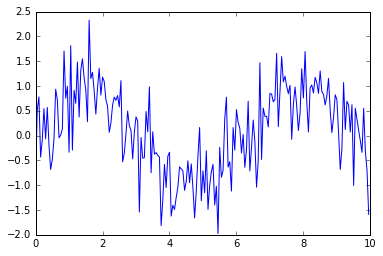

In [223]:
plt.plot(trainX,trainy);


### Demo of cloaking method

In [ ]:
mod = GPy.models.GPRegression(trainX,trainy)
mod.Gaussian_noise = 0.5**2/ystd
mod.rbf.lengthscale = 1.0
dpgp = DPGP_cloaking(mod,sens/ystd,1.0,0.01)

dpgp.plot()
plt.ylim([-2,2])

### Demo of Pseudo-inputs method

 /home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning:covariance is not positive-semidefinite.


(-2, 2)

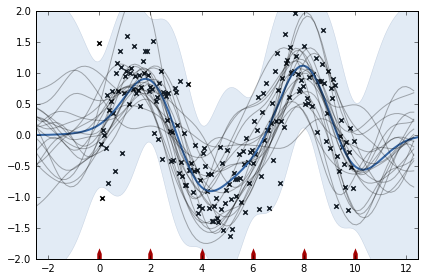

In [213]:
mod = GPy.models.SparseGPRegression(trainX,trainy,num_inducing=3)
mod.inference_method = GPy.inference.latent_function_inference.FITC()
mod.set_Z(np.array([[0,2,4,6,8,10]]).T)
mod.Gaussian_noise = 0.5**2/ystd
mod.rbf.lengthscale = 1.0
dpgp = DPGP_pseudo_prior(mod,10.0/ystd,100.0,0.01)
Xtest = np.arange(0,10,0.1)[:,None]
mu = dpgp.draw_prediction_samples(Xtest,20)

dpgp.plot()
plt.ylim([-2,2])

### Demo of standard GP method

 /home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning:covariance is not positive-semidefinite.


(-2, 2)

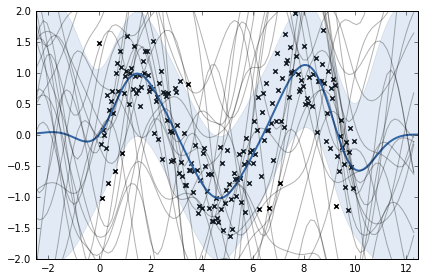

In [214]:
mod = GPy.models.GPRegression(trainX,trainy)
mod.Gaussian_noise = 0.5**2/ystd
mod.rbf.lengthscale = 1.0
dpgp = DPGP_normal_prior(mod,10.0/ystd,100.0,0.01)
#Xtest = np.arange(0,10,0.1)[:,None]
#mu = dpgp.draw_prediction_samples(Xtest,20)

dpgp.plot()
plt.ylim([-2,2])